# Классификация текстовых сообщений и улучшение метрик

In [1]:
import re
import random
import pymorphy3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm
%matplotlib inline

# Нужно раскоментировать чтобы работало построение разного рода графиков,
# но тогда на матрице ошибок возникают лишние линии
import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

import itertools

pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

import nltk
from nltk.corpus import stopwords

import itertools

import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad

from sklearn.ensemble import StackingClassifier, RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost # подключим библиотеку XGboost



## Подготовка к заданию:

- Каждому письму из набора писем (поле Content в файле mails.csv) проставлен класс (поле class). Все ФИО, названия, направления подготовки, специальности в письмах – сгенерированые. 

- Набор писем необходимо классифицировать, для этого необходимо датасет разбить на тренировочное/валидацонное (при необходимости)/тестовое множества, при этом количество записей в тестовом множестве должно составлять 10% от объема исходного датасета и необходимо сохранить пропорции классов в выборках (параметр stratify).



In [2]:
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

In [3]:
df = pd.read_excel('mails.xlsx')
print(df['class'].unique())
df['TYPE_HOTLINE'].unique()


[1 6 5 2 3 4 8 7]


array([2, 1, 3])

In [4]:
df.head(2)

,CONTENT,TYPE_HOTLINE,class
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6


In [5]:
# Меняем наименование столбца только для удобства
df.rename(columns={'CLASS_': 'lbl'}, inplace=True)

# Для удобства добавляем два столбца с наименованиями классов и каналов поствупления обращений.
cls_dic = {1:['Условия подачи','Условия подачи документов, сроки, документы, места, льготы'],
           2:['Проходной и допустимый балл','Минимальный проходной балл и Минимальный балл для подачи заявления'],
           3:['Достижения','Индивидуальные достижения.'],
           4:['Общежития','Общежития'],
           5:['Вступительные испытания','Вступительные испытания, экзамены, кто может поступать и сдавать экзамены'],
           6:['Перевод','Перевод с направления на направление'],
           7:['Аспирантура','Вопросы по аспирантуре'],
           8:['Регистрация','Регистрация в электронных системах'],
           }

hlt_dic = {1:'ONLINE приёмная',
           2:'Очная приемная',
           3:'Приёмная аспирантуры'
           }

df['cls_name'] = df['class'].map(lambda x: cls_dic[x][0])
df['hlt_name'] = df.TYPE_HOTLINE.map(lambda x: hlt_dic[x])
df.head()

,CONTENT,TYPE_HOTLINE,class,cls_name,hlt_name
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1,Условия подачи,Очная приемная
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6,Перевод,Очная приемная
2,Здравствуйте! Скажите пожалуйста могу ли я под...,2,1,Условия подачи,Очная приемная
3,Здравствуйте! Где взять и куда подать заявлени...,2,1,Условия подачи,Очная приемная
4,Здравствуйте! Есть два высших образования (пла...,2,1,Условия подачи,Очная приемная


In [6]:
# Сохранение в новый Excel файл
df.to_excel('processed_mails.xlsx', index=False)

In [7]:
# Классы сообщений:

cls_list = []
for i in range(1,len(cls_dic)+1):
  cls_list.append(cls_dic[i][0])

cls_list

['Условия подачи',
 'Проходной и допустимый балл',
 'Достижения',
 'Общежития',
 'Вступительные испытания',
 'Перевод',
 'Аспирантура',
 'Регистрация']

In [8]:
df.shape

(588, 5)

### Анализ, визуализация и сбалансированность датасета

cls_name
Аспирантура                      5
Вступительные испытания        155
Достижения                      29
Общежития                       28
Перевод                         42
Проходной и допустимый балл     24
Регистрация                     16
Условия подачи                 289
Name: cls_name, dtype: int64


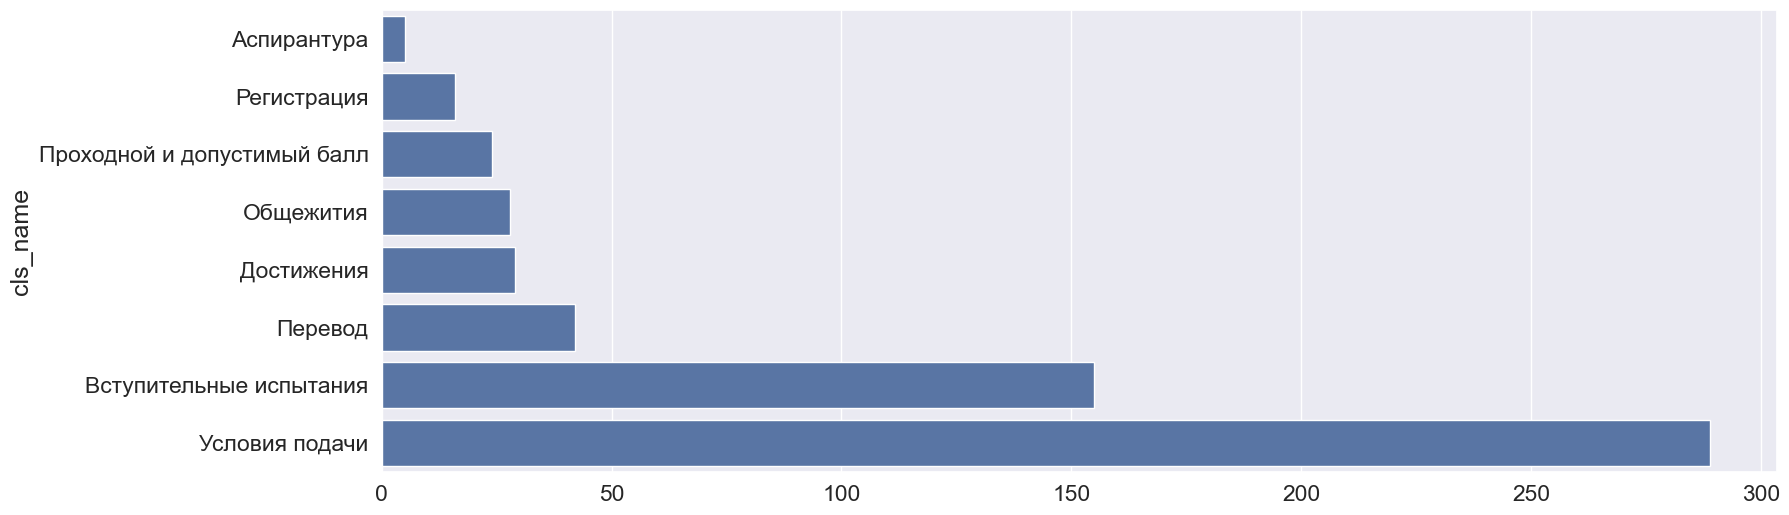

In [9]:
# Группировка данных по 'cls_name' и подсчет количества обращений
g = df.groupby('cls_name')['cls_name'].count().sort_values()

# Вывод количества обращений по классам
print(df.groupby('cls_name')['cls_name'].count())

# Увеличиваем масштаб шрифта для графика
sns.set(font_scale=1.5)

# Создаем график
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x=g.values, y=g.index, orient='h', ax=ax)

# Отображение графика
plt.show()

<Axes: ylabel='TYPE_HOTLINE'>

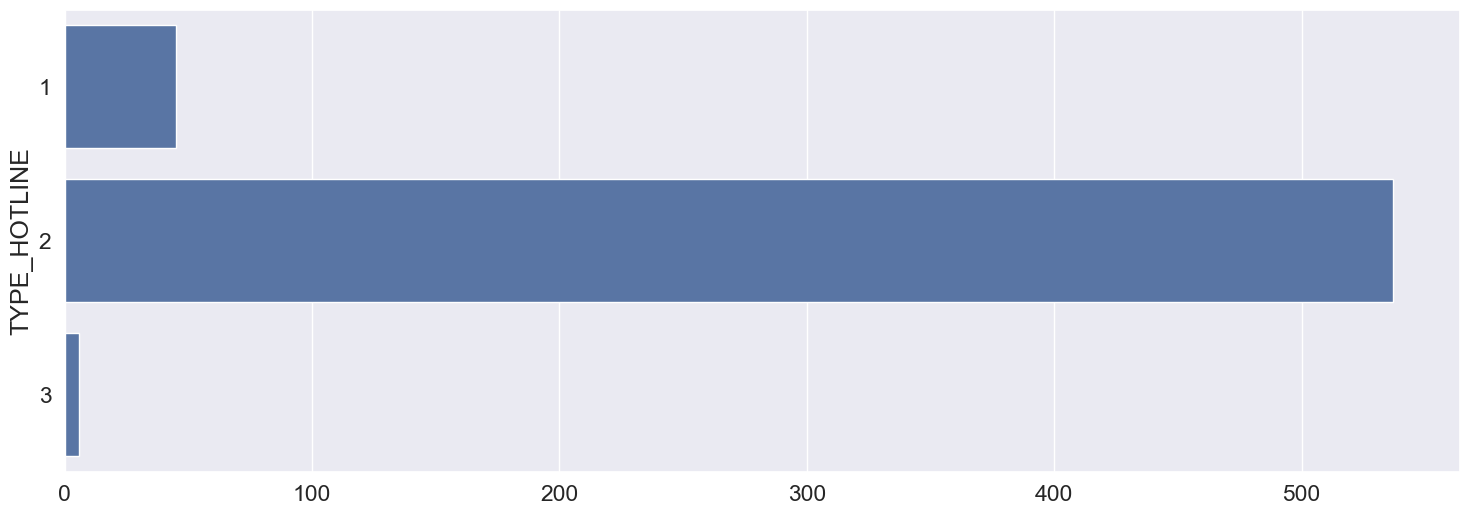

In [10]:
g = df.groupby('TYPE_HOTLINE')['TYPE_HOTLINE'].count().sort_values()
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x=g.values, y=g.index, orient='h')

--------------------------------------

## Задача 1. Обработка текста для улучшения метрик классификации. Подготовка данных
Предобработка текста писем: удаление из текста лишней информации, которая не нужна для получения основной мысли сообщения и классификации его.

In [11]:
# Загрузим дополнительные стоп-слова для русского языка
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Дополнительные стоп-слова из текста
words_parasites = [
    'спасибо',
    'подскажите',
    'расскажите',
    'скажите',
    'объясните',
    'пожалуйста', 
    'здравствуйте',
    'здравствуйте!',
    'добрый день',
    'уважнием',
    'ли',
    'бы',
    'есть ли',
    'будет ли',
    'до свидания', 
    'доброго времени суток', 
    'доброго дня', 
    'hello', 
    'с уважением',
    'то',
    'вообще',
    'хотеть',
    'хотеться',
    'узнать',
    'уточнить', 
    'уважение',
    'значит',
    'ну',
    'да',
    'ладно',
    'как бы',
    'вот',
    'собственно',
    'в принципе',
    'на самом деле',
    'мне кажется',
    'например',
    'получается',
    'в общем',
    'наверное',
    'так сказать',
    'короче',
    'еще раз',
    'суть в том',
    'по сути',
    'кстати',
    'типа',
    'вроде',
    'в общем-то',
    'все-таки',
    'по-моему',
    'так вот',
    'всё же',
    'ну вот',
    'просто',
    'как-то',
    'ну и',
    'не знаю',
    'не факт',
    'там',
    'еще что-то',
    'потом',
    'между прочим',
    'по-моему',
    'по идее',
    'должен сказать',
    'по факту',
    'всё равно',
    'смотрите',
    'в любом случае',
    'сейчас',
    'после того как',
    'в любом случае',
    'даже',
    'наверное',
    'возможно',
    'так что',
    'так-то',
    'честно говоря',
    'знаете ли',
    'давай',
    'как раз',
    'весьма',
    'когда-то',
    'что-то',
    'чё',
    'пойми',
    'чем-то'
]


In [13]:
# Объединяем стандартные стоп-слова и пользовательские
words_parasites = set(russian_stopwords + words_parasites)

In [14]:
# Приведение слов в нормальную форму
def morphan(word, morph):
    '''
    Приведение слов в нормальную форму, удаление числительных и ФИО.
    '''
    word = word.strip()  # Удаляет пробелы до и после слова
    p = morph.parse(word)[0]  # Разбираем (анализируем) слово с pymorphy3

    word_new = word
    if (not 'Surn' in p.tag) and (not 'Name' in p.tag) and (not 'Patr' in p.tag) and ('NOUN' in p.tag):
        #существительное не ФИО
        word_new = p.normal_form
    elif 'Surn' in p.tag:
        word_new = 'ФАМИЛИЯ'
    elif 'Name' in p.tag:
        word_new = 'ИМЯ'
    elif 'Patr' in p.tag:
        word_new = 'ОТЧЕСТВО'


    elif ('INFN' in p.tag) or ('VERB' in p.tag): #глагол
        word_new = p.normal_form

    elif ('ADJF' in p.tag) or ('ADJS' in p.tag) or ('COMP' in p.tag): #прилагательное
        word_new = p.normal_form


    elif ('PRTF' in p.tag) or ('PRTS' in p.tag) or ('GRND' in p.tag): #причастие, похоже на глагол
        word_new = p.normal_form

    elif ('ADVB' in p.tag) or ('NPRO' in p.tag) or ('PRED' in p.tag) or ('PREP' in p.tag) or ('CONJ' in p.tag) or ('PRCL' in p.tag) or ('INTJ' in p.tag):
        # предлоги, местоимения и пр.
        word_new = p.normal_form

    elif ('NUMR' in p.tag) or ('NUMB' in p.tag) or ('intg' in p.tag): # числительные NUMB,intg
        word_new = ''

    else:
        word_new = word

    # Убираем слова паразиты
    if word_new in words_parasites:
        word_new = ''
    return word_new

def normtext(txt, morph):
    '''
    Возвращает текст из слов в нормальной форме
    '''
    # Убираем лишние символы и заменяем их на пробелы
    txt = re.sub(r"[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+", ' ', txt)
    
    # Лемматизация, приведение слов к их базовой форме, Удаление стоп-слов
    txt = str(' '.join([morphan(x, morph) for x in txt.split()]))
    
    # Убираем лишние пробелы
    txt = re.sub(r'\s+', ' ', txt)

    # Убираем пробелы в начале и конце строки
    txt = txt.strip()

    return txt


In [15]:
morph = pymorphy3.MorphAnalyzer()
txt = 'Здравствуйте! Если не нужно размещать документы в личном кабинете студента для заселения в общежитие, то куда вообще подавать их?'
processed_txt = normtext(txt, morph)
print(processed_txt)

нужно размещать документ личный кабинет студент заселение общежитие подавать


In [16]:
# Применяем обработку ко всем данным в DataFrame
df['processed_text'] = df['CONTENT'].map(lambda x: normtext(x, morph))

In [17]:
# Сохраняем обработанные данные
df.to_excel('df_prep.xlsx', index=False)

--------------------------------------

## Задача 2. Эксперименты с нейронными сетями. ML - Классификация
Основная задача (обязательная для решения). Разработать программу для классификации обращений (писем).

### Dropout: параметр, который помогает избежать переобучения сети, отключая случайные нейроны во время обучения.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.processed_text, df['class'], random_state=42, test_size=0.3)

tfv = TfidfVectorizer()  # Функция получения векторного представления
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

param_grid = {'C': [1.,10.0]}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

grid_search.best_params_

{'C': 10.0}

In [19]:
def classifier(X_train, y_train, C=10.):
    '''
    Возвращает обученный классификатор и векторизатор.
    '''

    tfv = TfidfVectorizer()
    X_train = tfv.fit_transform(X_train)

    clf = LogisticRegression(C=C)
    clf = clf.fit(X_train, y_train)

    return tfv, clf

def predictor(text, clf, tfv):
    '''
    text - классифицируемый текс
    clf - обученный классификатор
    tfv - обученный векторизатор

    '''
    X_test = tfv.transform([text])

    pred = clf.predict(X_test)

    return pred[0]

In [20]:
# Обучение
X_train, X_test, y_train, y_test = train_test_split(df.processed_text, df['class'], random_state=42, test_size=0.3)
tfv, clf = classifier(X_train, y_train, C=10.0)

In [21]:
# Т.к. вопрорсов по аспирантуре мало, и в них в основном встречается подстрока 'аспирант', то можно записи проклассифицировать по наличию этой подстроки

def find_aspirant(txt):
    '''
    Возвращает True если в тексте есть слово, начинающееся на 'аспирант'
    '''
    return 'аспирант' in [x[:8] for x in txt.split()]

In [22]:
# Предсказание
pred_save = []
class_save = []
pred = []
print(X_test.shape)
for nom, txt in enumerate(X_test.values):
    if find_aspirant(txt):
        # УДАЛЕНИЕ "аспирант" по подстроке
        pred_save.append(7)
        del_index = X_test.index.to_numpy()[nom]
        X_test = X_test.drop(index=[del_index])
        class_save.append(y_test[y_test.index==del_index].values[0])
        y_test = y_test.drop(index=[del_index])
    else:
        pred.append(predictor(txt, clf, tfv))
print(X_test.shape)


(177,)
(176,)


In [23]:
y_test_list = y_test.tolist()
y_test_list.extend(class_save)
pred_list = pred[:]
pred_list.extend(pred_save)

mtrs = classification_report([cls_dic[x][0] for x in y_test_list], [cls_dic[x][0] for x in pred_list])
print(mtrs)

                             precision    recall  f1-score   support

                Аспирантура       1.00      1.00      1.00         1
    Вступительные испытания       0.96      0.90      0.93        49
                 Достижения       0.71      0.62      0.67         8
                  Общежития       0.45      1.00      0.62         5
                    Перевод       0.67      0.33      0.44         6
Проходной и допустимый балл       1.00      0.55      0.71        11
                Регистрация       1.00      0.25      0.40         8
             Условия подачи       0.85      0.97      0.91        89

                   accuracy                           0.85       177
                  macro avg       0.83      0.70      0.71       177
               weighted avg       0.87      0.85      0.84       177



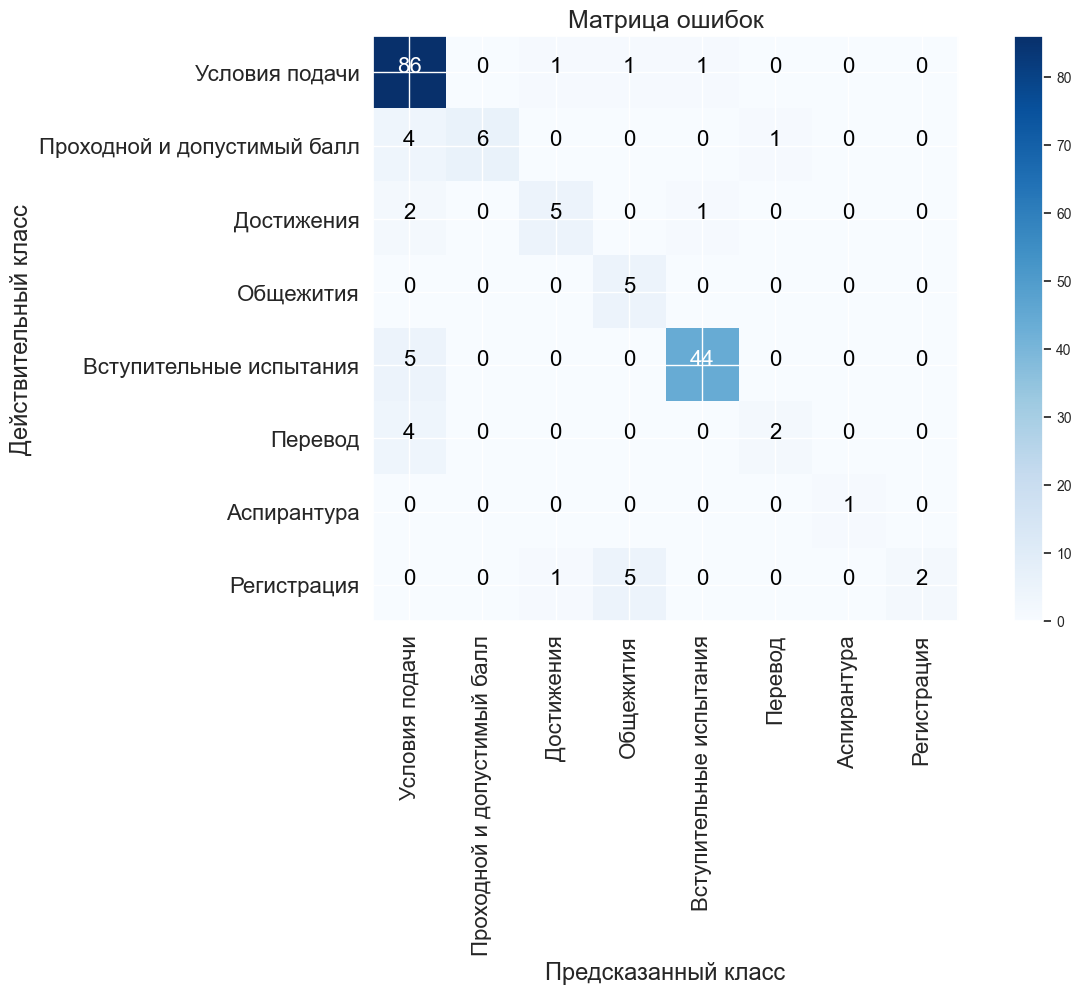

In [52]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.show()

# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y_test_list, pred_list)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

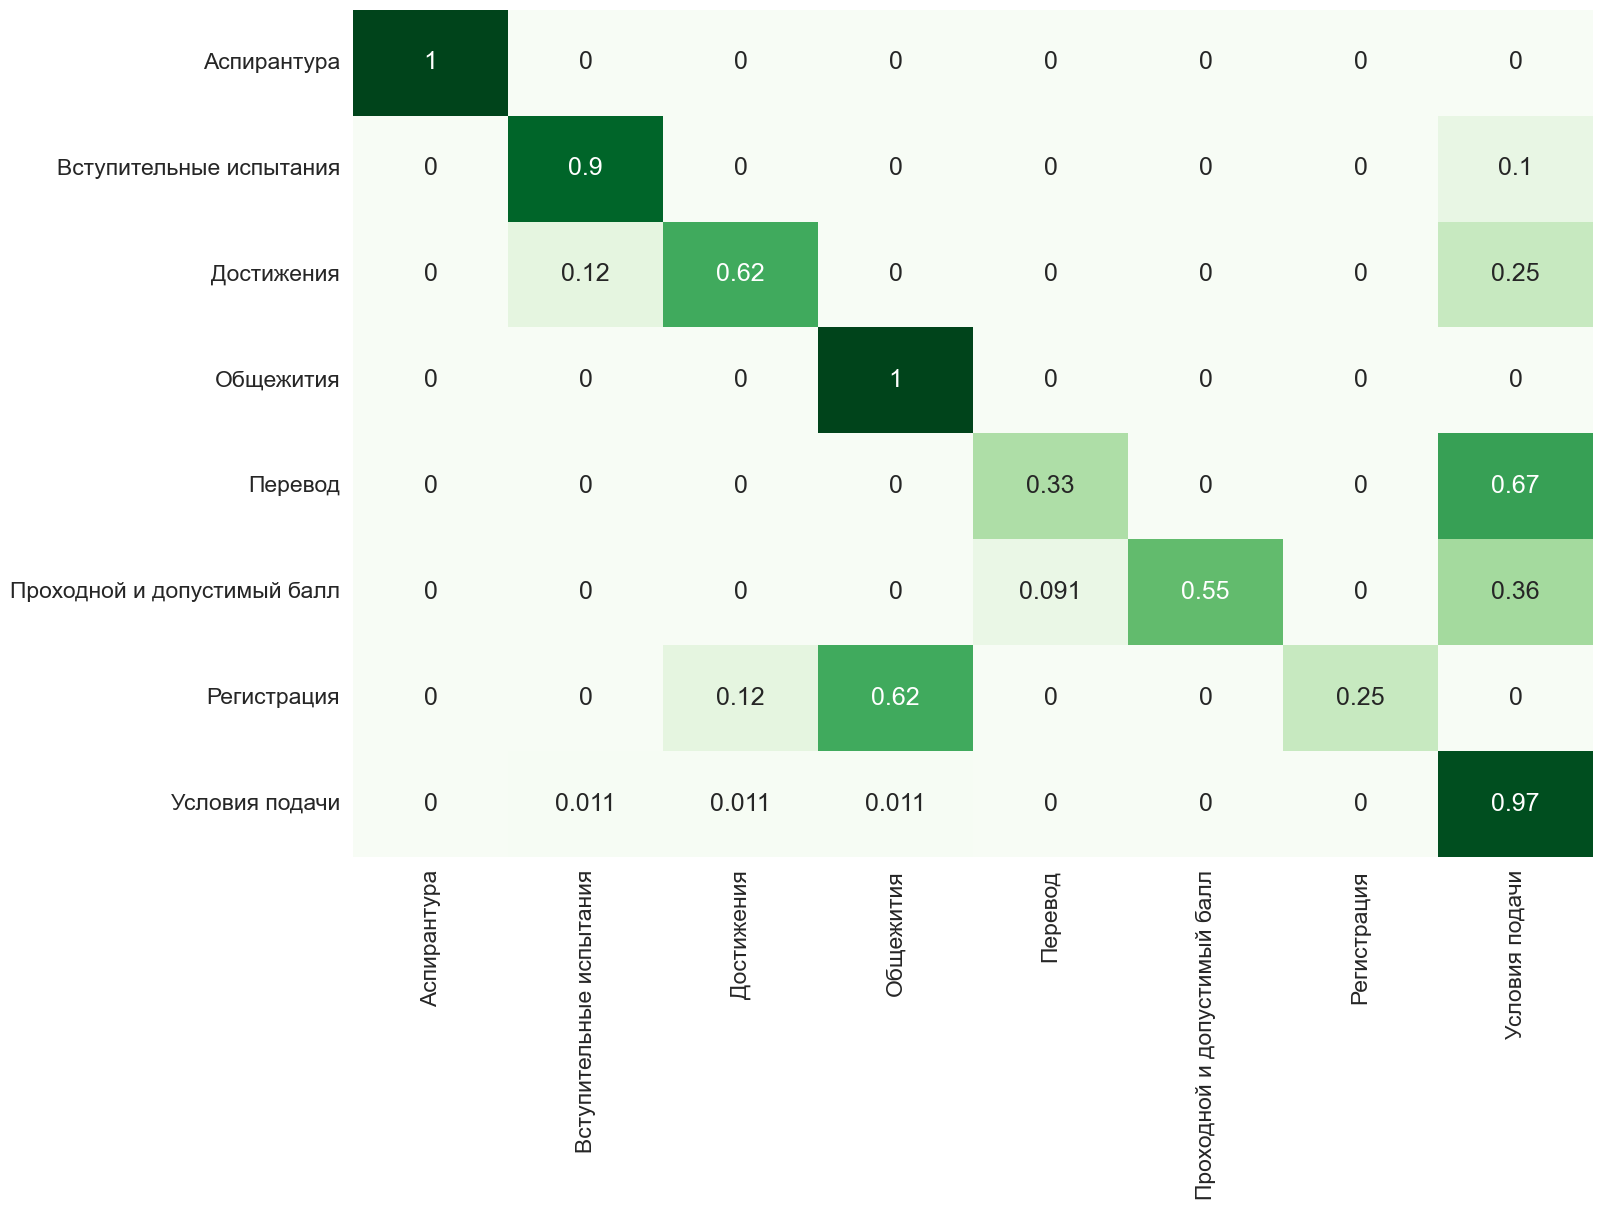

In [25]:
y_te = [cls_dic[i][0] for i in y_test_list]
y_pr = [cls_dic[i][0] for i in pred_list]
mat = confusion_matrix(y_te, y_pr, normalize='true')
mat = pd.DataFrame(mat, index=np.unique(y_te), columns=np.unique(y_pr))

f, ax = plt.subplots(figsize=(16, 11))
sns_plot = sns.heatmap(mat, annot=True, cbar=False, cmap="Greens")

#### RNN - классификация

In [26]:
# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(X_train)

In [27]:
X_train_1, X_vt_1, y_train_1, y_vt_1 = train_test_split(df.processed_text, df['class'], random_state=42, test_size=0.3)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_vt_1, y_vt_1, test_size=0.5, random_state=42)

In [28]:
# Максимальное количество слов в самом длинном письме
max_words = 0
for desc in df.processed_text.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном письме: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = max_words

Максимальное количество слов в самом длинном письме: 64 слов
Всего уникальных слов в словаре: 1121


In [29]:
# Преобразуем описания заявок в векторы чисел
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.processed_text)

X_train = tokenizer.texts_to_sequences(X_train_1)
X_valid = tokenizer.texts_to_sequences(X_valid_1)
X_test = tokenizer.texts_to_sequences(X_test_1)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_valid:', X_valid.shape)
print('Размерность X_test:', X_test.shape)

# Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)

num_classes = df['class'].unique().shape[0]+1

y_train = keras.utils.to_categorical(y_train_1, num_classes)
y_valid = keras.utils.to_categorical(y_valid_1, num_classes)
y_test = keras.utils.to_categorical(y_test_1, num_classes)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

Размерность X_train: (411, 64)
Размерность X_valid: (88, 64)
Размерность X_test: (89, 64)
y_train shape: (411, 9)
y_valid shape: (88, 9)
y_test shape: (89, 9)


Собираем модель...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.3605 - loss: 2.1574 - val_accuracy: 0.5000 - val_loss: 1.9662
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5183 - loss: 1.8373 - val_accuracy: 0.5000 - val_loss: 1.6201
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4972 - loss: 1.5658 - val_accuracy: 0.5000 - val_loss: 1.5148
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4812 - loss: 1.4603 - val_accuracy: 0.5000 - val_loss: 1.4568
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4961 - loss: 1.4565 - val_accuracy: 0.5000 - val_loss: 1.4317
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4926 - loss: 1.4345 - val_accuracy: 0.5341 - val_loss: 1.3781
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5268 - loss: 1.3921 - val_accuracy: 0.5909 - val_loss: 1.3150
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6031 - loss: 1.2482 -

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

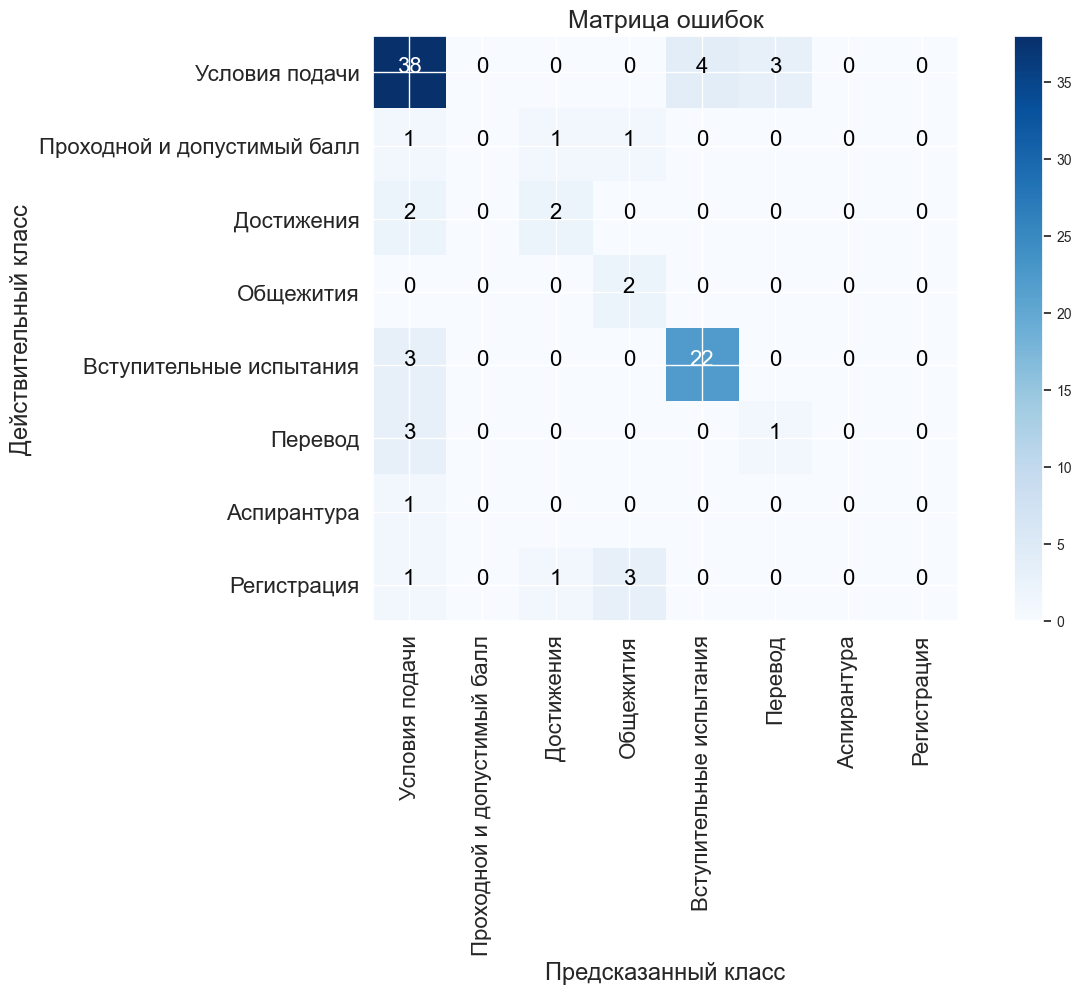

In [30]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))

conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

### Количество нейронов и размерность слоя Embedding: изменение этих значений может помочь лучше обучить модель на признаках текста.

Собираем модель...
Тренируем модель...
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.2991 - loss: 2.1795 - val_accuracy: 0.5114 - val_loss: 2.1153
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5504 - loss: 2.0724 - val_accuracy: 0.5114 - val_loss: 1.9311
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5130 - loss: 1.8380 - val_accuracy: 0.4886 - val_loss: 1.6714
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4736 - loss: 1.5774 - val_accuracy: 0.5000 - val_loss: 1.5303
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4907 - loss: 1.5127 - val_accuracy: 0.5000 - val_loss: 1.4912
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4816 - loss: 1.4850 - val_accuracy: 0.5000 - val_loss: 1.4748
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4682 - loss: 1.4311 - val_accuracy: 0.5000 - val_loss: 1.4479
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4878 - loss: 1.3662 - 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

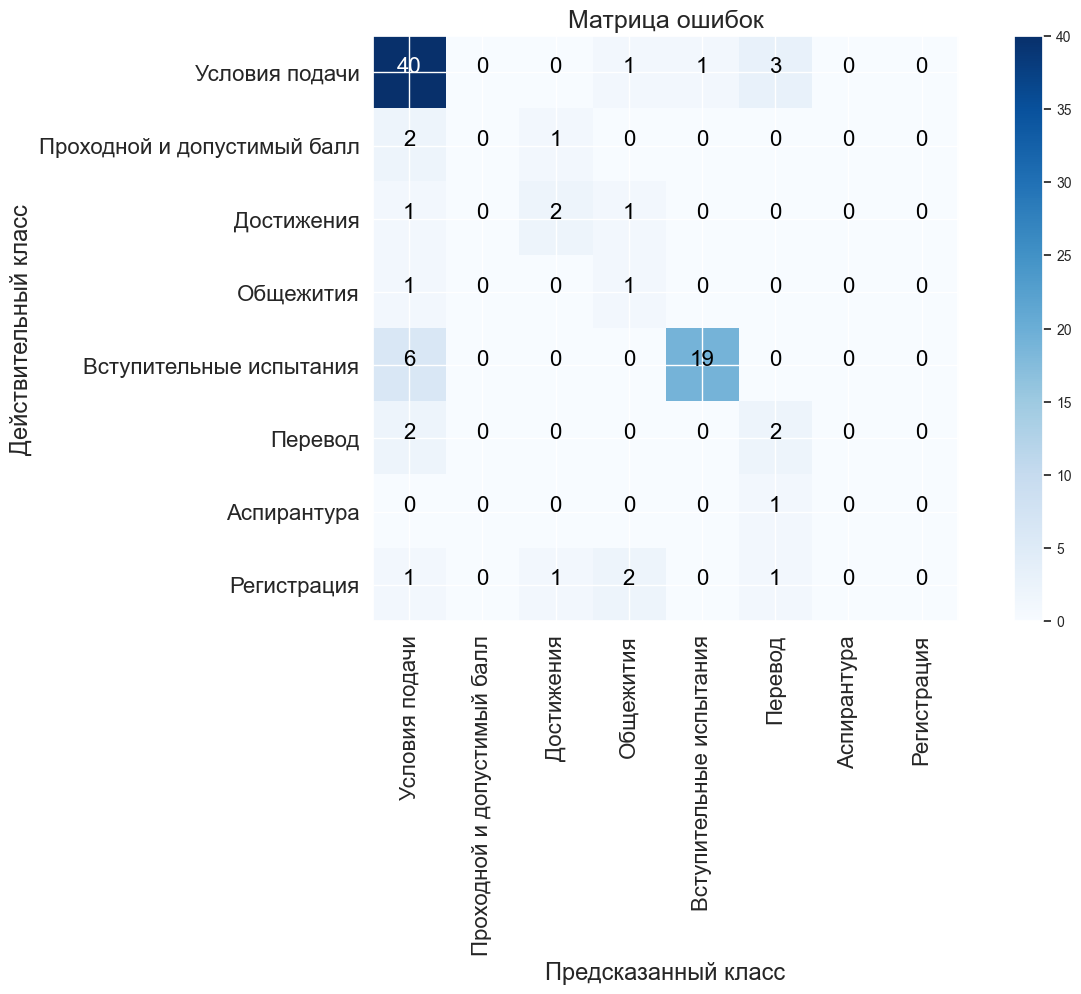

In [31]:
# максимальное количество слов для анализа
max_features = 10000  # Размер словаря
# embedding_dim = 300  # Размерность для эмбеддинга
embedding_dim = maxSequenceLength  # Размерность для эмбеддинга

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

# Настройки тренировки
batch_size = 64  # Можно попробовать увеличить размер батча
epochs = 30  # Увеличим количество эпох

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid))

# Предсказания
predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))

# Матрица ошибок
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Тренируем модель...
Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.2346 - loss: 2.1827 - val_accuracy: 0.5000 - val_loss: 2.1033
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4708 - loss: 2.0776 - val_accuracy: 0.5000 - val_loss: 1.9259
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4642 - loss: 1.9073 - val_accuracy: 0.5000 - val_loss: 1.6669
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5107 - loss: 1.6837 - val_accuracy: 0.5000 - val_loss: 1.5179
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5076 - loss: 1.5173 - val_accuracy: 0.5000 - val_loss: 1.4387
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4882 - loss: 1.5191 - val_accuracy: 0.5000 - val_loss: 1.3926
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.4988 - loss: 1.4430 - val_accuracy: 0.5000 - val_loss: 1.3770
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5229 - loss: 1.4317 - val_ac

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

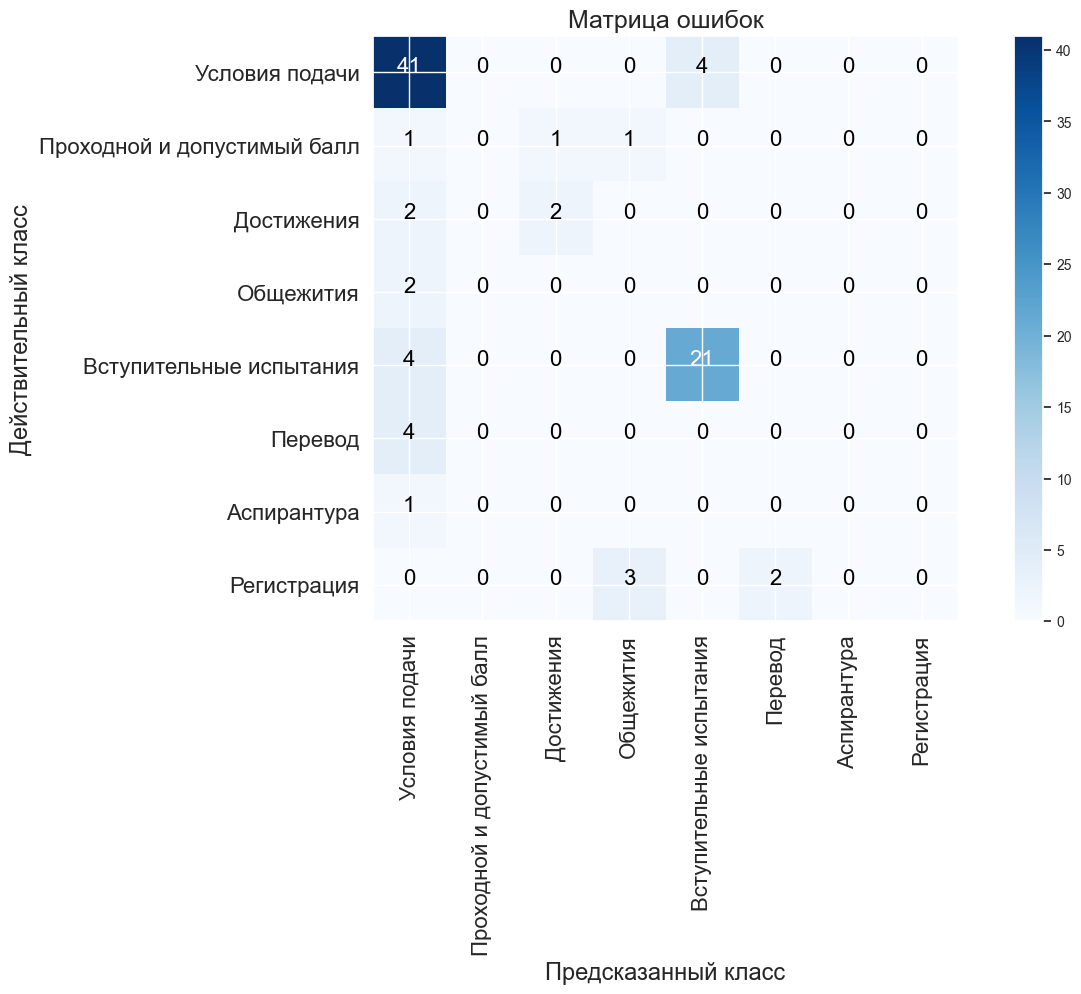

In [32]:
# максимальное количество слов для анализа
max_features = 10000  # Размер словаря
embedding_dim = maxSequenceLength  # Размерность для эмбеддинга

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(model.summary())

# Настройки тренировки
batch_size = 64  # Можно попробовать увеличить размер батча
epochs = 30  # Увеличим количество эпох

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid))

# Предсказания
predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))

# Матрица ошибок
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

### Оптимизаторы: вы можете применить различные оптимизаторы, такие как Adam, SGD, RMSprop, для улучшения обучения модели.

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.3641 - loss: 2.0804 - val_accuracy: 0.5000 - val_loss: 1.5047
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4819 - loss: 1.5270 - val_accuracy: 0.5000 - val_loss: 1.4350
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5103 - loss: 1.4324 - val_accuracy: 0.5114 - val_loss: 1.3990
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5592 - loss: 1.3409 - val_accuracy: 0.6136 - val_loss: 1.2497
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.7017 - loss: 1.1005 - val_accuracy: 0.7045 - val_loss: 1.0651
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7325 - loss: 0.9106 - val_accuracy: 0.6932 - val_loss: 0.9499
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8000 - loss: 0.6880 - val_accuracy: 0.7727 - val_loss: 0.8467
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.83

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

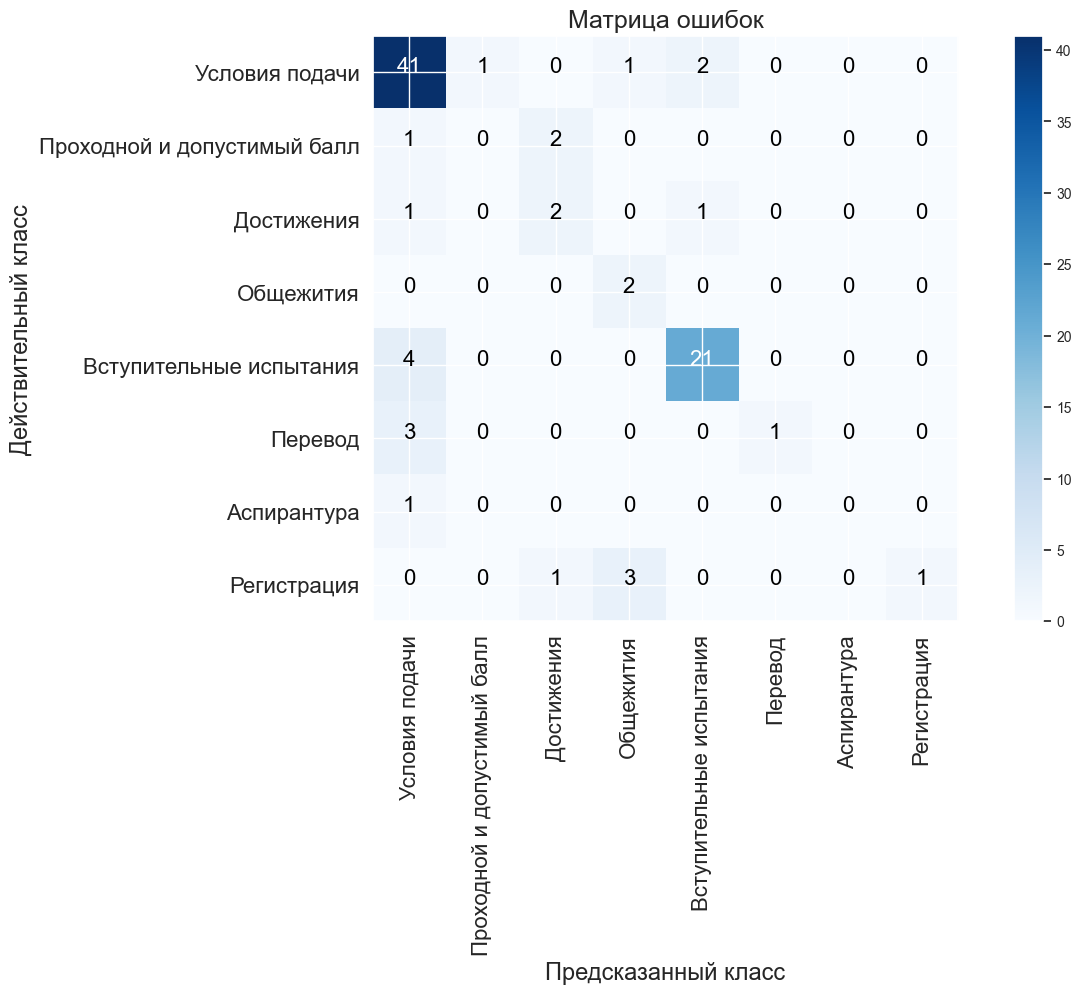

In [33]:
# максимальное количество слов для анализа
max_features = 10000  # Размер словаря
embedding_dim = 300  # Размерность для эмбеддинга

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.3492 - loss: 2.1595 - val_accuracy: 0.5000 - val_loss: 2.0604
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.4924 - loss: 2.0315 - val_accuracy: 0.5000 - val_loss: 1.9439
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4808 - loss: 1.9220 - val_accuracy: 0.5000 - val_loss: 1.7960
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5027 - loss: 1.7599 - val_accuracy: 0.5000 - val_loss: 1.6226
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4882 - loss: 1.6307 - val_accuracy: 0.5000 - val_loss: 1.5240
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.4917 - loss: 1.5332 - val_accuracy: 0.5000 - val_loss: 1.4927
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4952 - loss: 1.4977 - val_accuracy: 0.5000 - val_loss: 1.4821
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

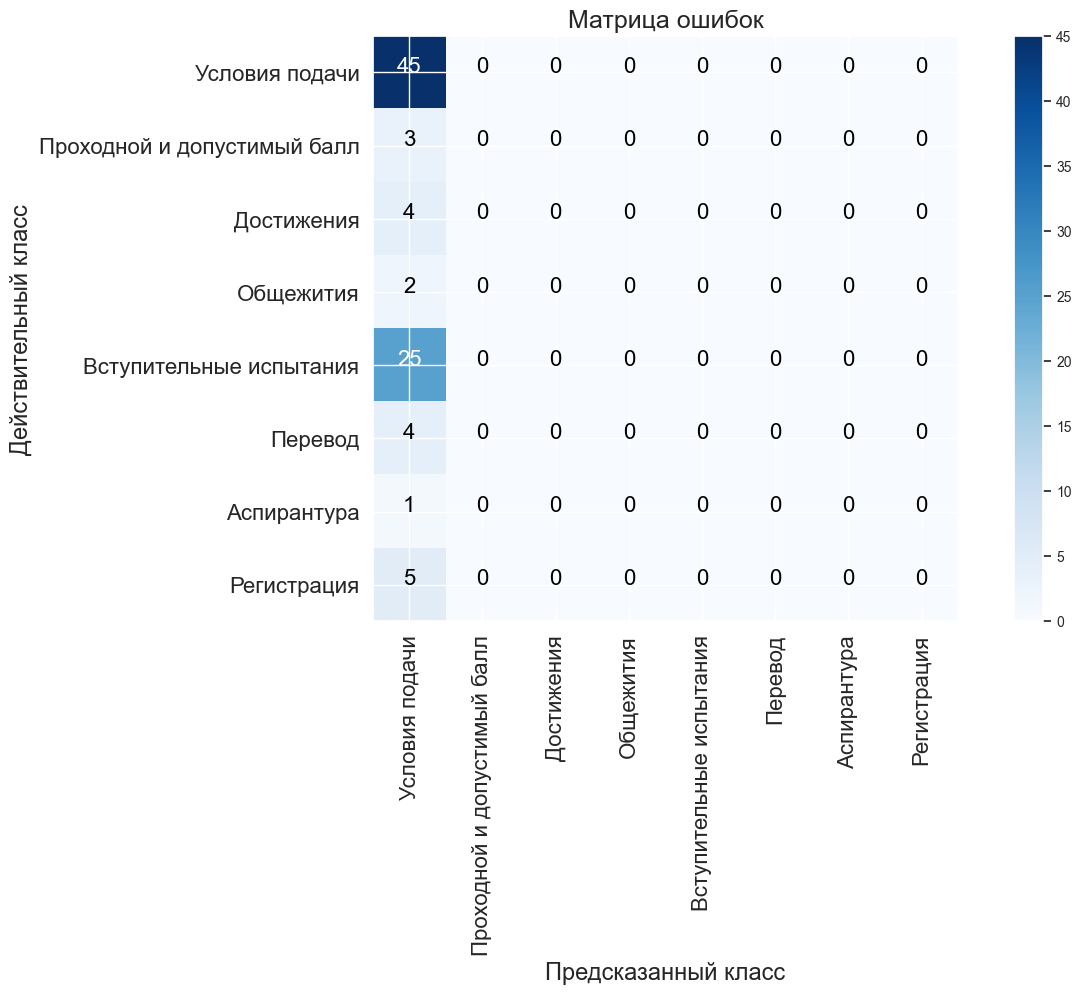

In [34]:
# максимальное количество слов для анализа
max_features = 10000  # Размер словаря
embedding_dim = 300  # Размерность для эмбеддинга

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

optimizer = Adagrad(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.4394 - loss: 1.9272 - val_accuracy: 0.5000 - val_loss: 1.4695
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4825 - loss: 1.5203 - val_accuracy: 0.5000 - val_loss: 1.4351
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4967 - loss: 1.4020 - val_accuracy: 0.5568 - val_loss: 1.3593
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5535 - loss: 1.2944 - val_accuracy: 0.6705 - val_loss: 1.2387
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6060 - loss: 1.2932 - val_accuracy: 0.6136 - val_loss: 1.1481
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6860 - loss: 1.0462 - val_accuracy: 0.6818 - val_loss: 1.0210
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6633 - loss: 0.9913 - val_accuracy: 0.6705 - val_loss: 0.9911
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7074 -

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

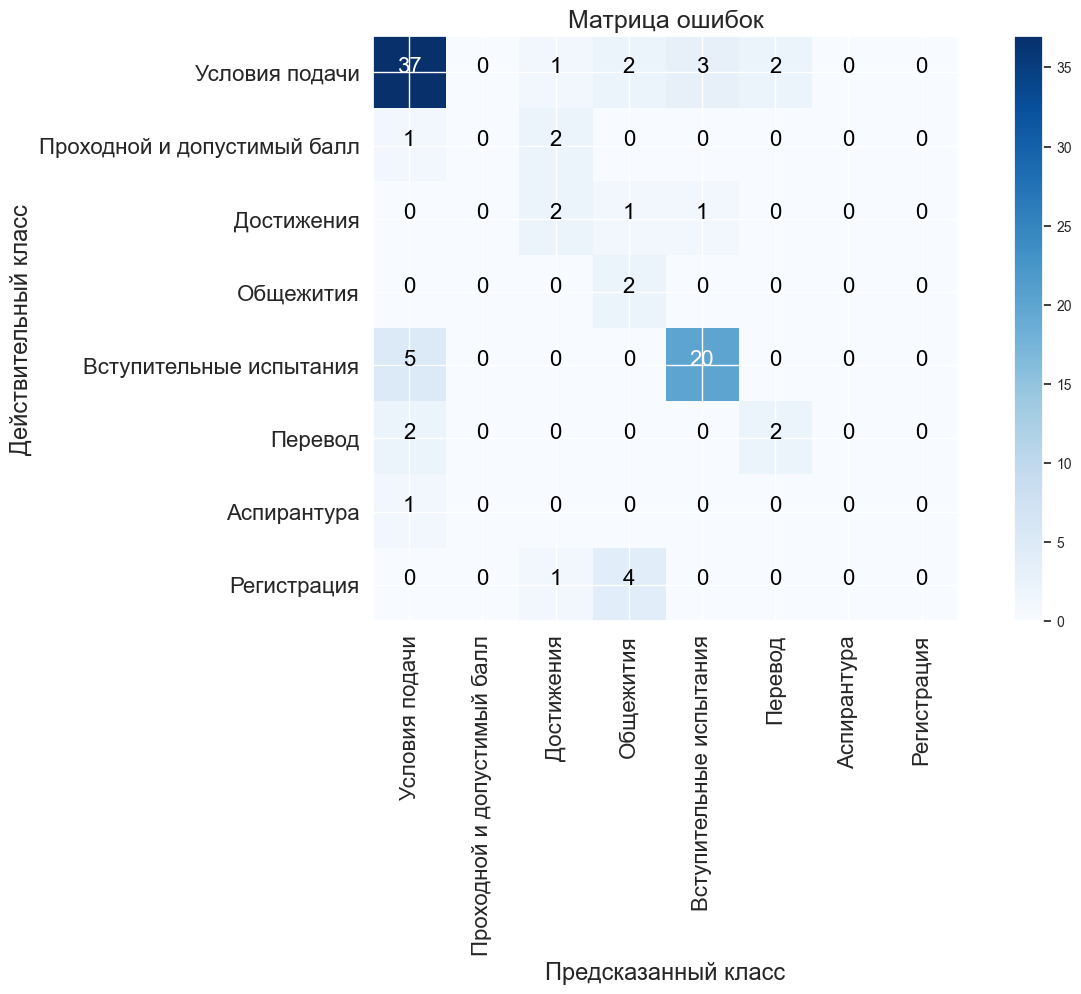

In [35]:
# максимальное количество слов для анализа
max_features = 10000  # Размер словаря
embedding_dim = 300  # Размерность для эмбеддинга

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, embedding_dim))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

optimizer = RMSprop(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

### Функции активации: например, ReLU, tanh или sigmoid, которые влияют на то, как нейроны обучаются.

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.3211 - loss: 2.1550 - val_accuracy: 0.5000 - val_loss: 1.9217
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4950 - loss: 1.7704 - val_accuracy: 0.5000 - val_loss: 1.5650
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5041 - loss: 1.5092 - val_accuracy: 0.5000 - val_loss: 1.4933
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5143 - loss: 1.3833 - val_accuracy: 0.5000 - val_loss: 1.4658
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4927 - loss: 1.4430 - val_accuracy: 0.5227 - val_loss: 1.4191
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5498 - loss: 1.3361 - val_accuracy: 0.6023 - val_loss: 1.3345
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6460 - loss: 1.2207 - val_accuracy: 0.6591 - val_loss: 1.2240
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7034 -

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

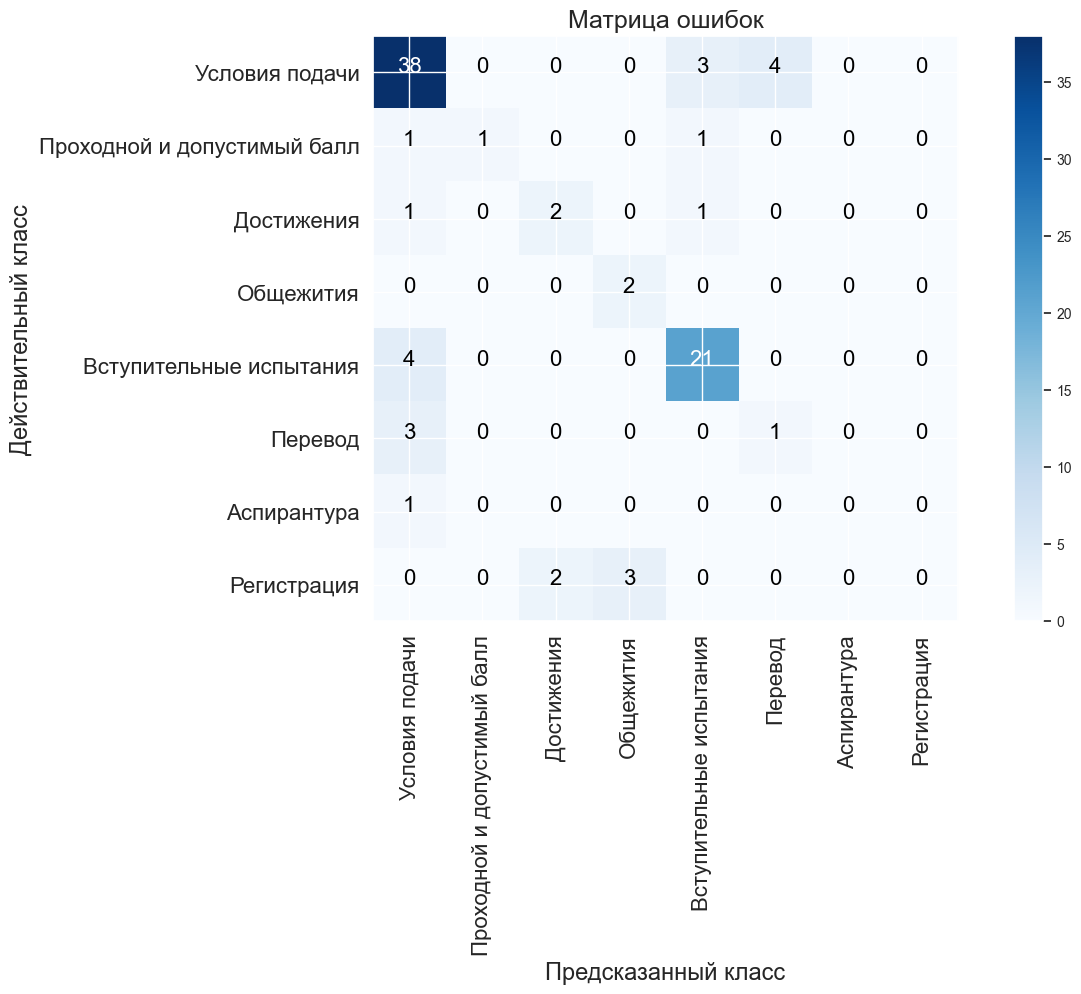

In [37]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.1554 - loss: 7.1193 - val_accuracy: 0.1364 - val_loss: 7.3713
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.1043 - loss: 10.3300 - val_accuracy: 0.1023 - val_loss: 11.5391
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1255 - loss: 11.5220 - val_accuracy: 0.1818 - val_loss: 11.3559
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.1719 - loss: 12.0015 - val_accuracy: 0.2045 - val_loss: 10.5647
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1625 - loss: 11.1280 - val_accuracy: 0.2159 - val_loss: 9.9755
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.1896 - loss: 11.4226 - val_accuracy: 0.2273 - val_loss: 10.2750
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2302 - loss: 11.8449 - val_accuracy: 0.2386 - val_loss: 9.8906
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

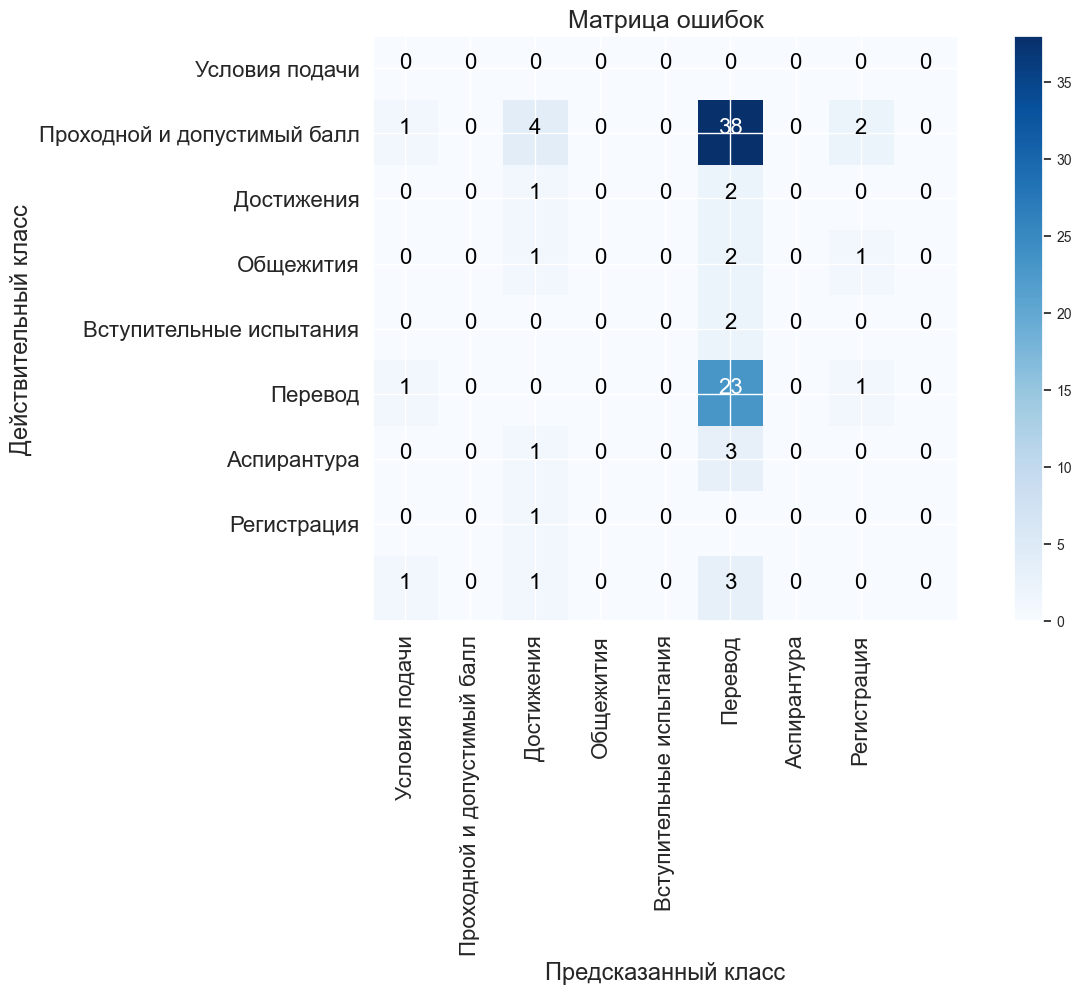

In [38]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='swish'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

### Функции потерь: возможно, вам нужно будет изменить функцию потерь в зависимости от того, какой тип задачи классификации (например, многоклассовая или бинарная) вы решаете.

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3219 - loss: 1.0013 - val_accuracy: 0.5568 - val_loss: 0.9987
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5862 - loss: 0.9969 - val_accuracy: 0.6023 - val_loss: 0.9941
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6518 - loss: 0.9898 - val_accuracy: 0.5909 - val_loss: 0.9705
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5940 - loss: 0.9386 - val_accuracy: 0.6364 - val_loss: 0.8565
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6311 - loss: 0.8179 - val_accuracy: 0.6250 - val_loss: 0.7050
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6719 - loss: 0.6718 - val_accuracy: 0.7159 - val_loss: 0.6464
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7000 - loss: 0.6030 - val_accuracy: 0.7159 - val_loss: 0.6227
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7367 - 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

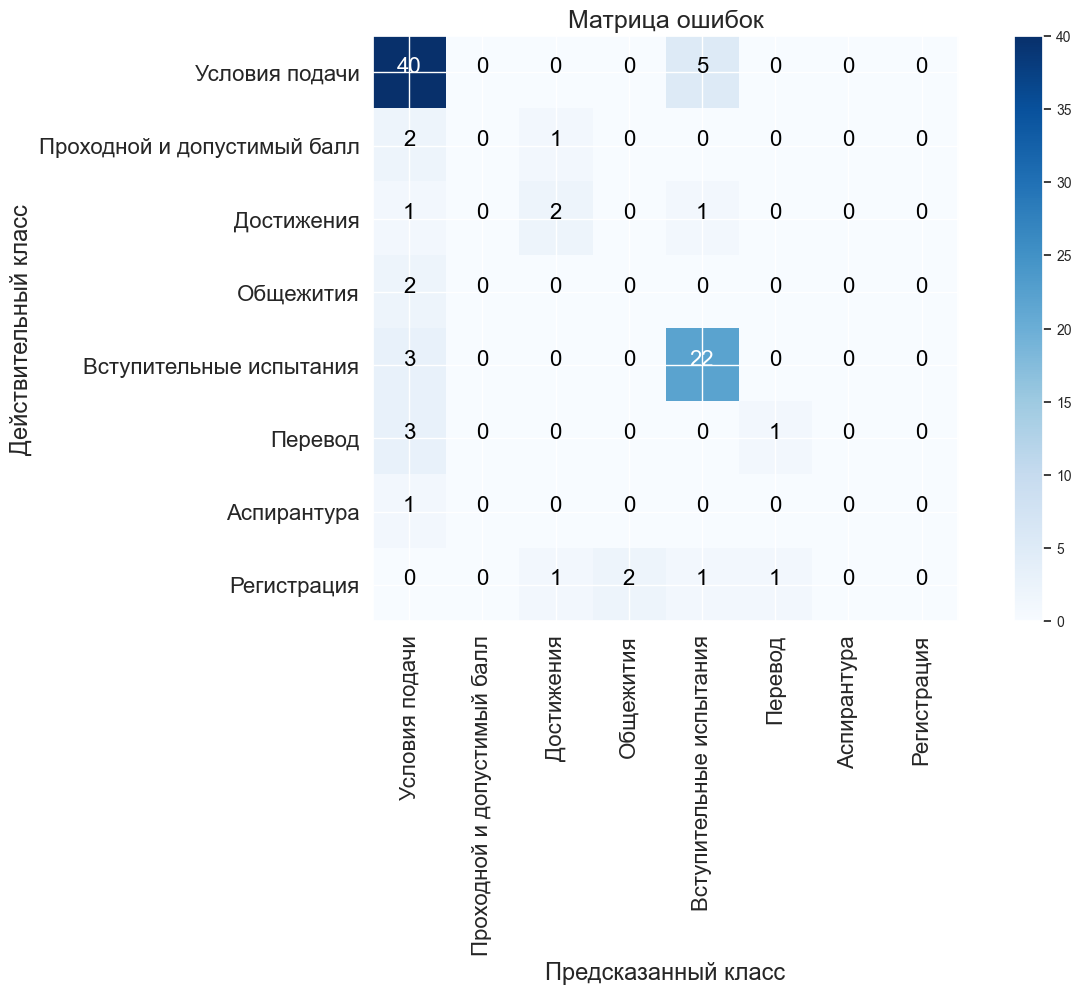

In [39]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.2690 - loss: -0.3423 - val_accuracy: 0.4205 - val_loss: -0.3929
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4660 - loss: -0.4314 - val_accuracy: 0.5000 - val_loss: -0.5606
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5201 - loss: -0.5664 - val_accuracy: 0.5000 - val_loss: -0.5801
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4775 - loss: -0.5709 - val_accuracy: 0.5000 - val_loss: -0.5928
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4922 - loss: -0.5885 - val_accuracy: 0.5227 - val_loss: -0.6124
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6044 - loss: -0.6370 - val_accuracy: 0.6364 - val_loss: -0.6601
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7040 - loss: -0.7149 - val_accuracy: 0.6705 - val_loss: -0.7010
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accu

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

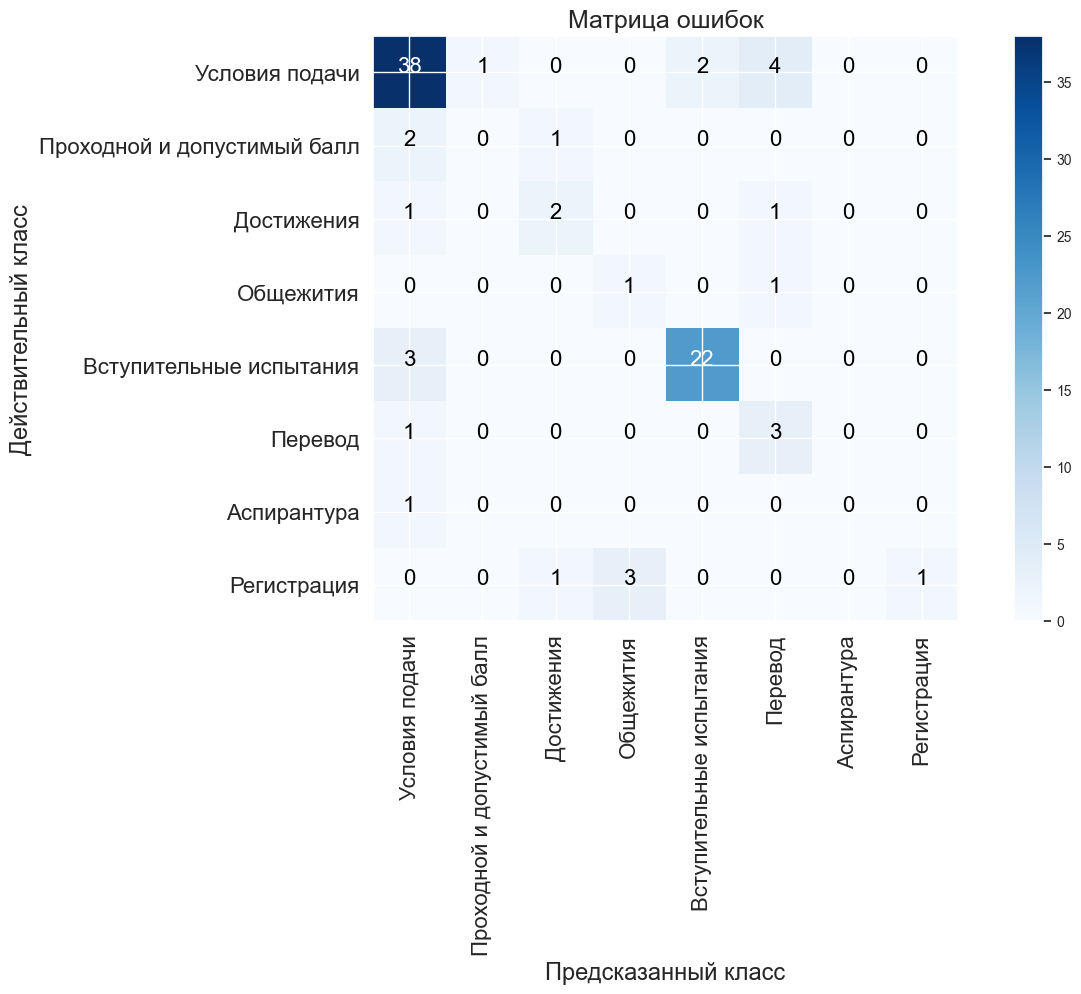

In [40]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='cosine_similarity',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

### Заменить слой LSTM на GRU: GRU (Gated Recurrent Unit) — это аналог LSTM, но с меньшим количеством параметров и, возможно, более быстрым обучением.

{'C': 10.0}

Собираем модель...
Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.3090 - loss: 1.0018 - val_accuracy: 0.5114 - val_loss: 0.9994
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5175 - loss: 0.9973 - val_accuracy: 0.5682 - val_loss: 0.9968
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5855 - loss: 0.9901 - val_accuracy: 0.5909 - val_loss: 0.9870
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5510 - loss: 0.9521 - val_accuracy: 0.5341 - val_loss: 0.9319
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5470 - loss: 0.8301 - val_accuracy: 0.5682 - val_loss: 0.8785
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6102 - loss: 0.7250 - val_accuracy: 0.5909 - val_loss: 0.7896
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6774 - loss: 0.6236 - val_accuracy: 0.6364 - val_loss: 0.7393
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7315 - 

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

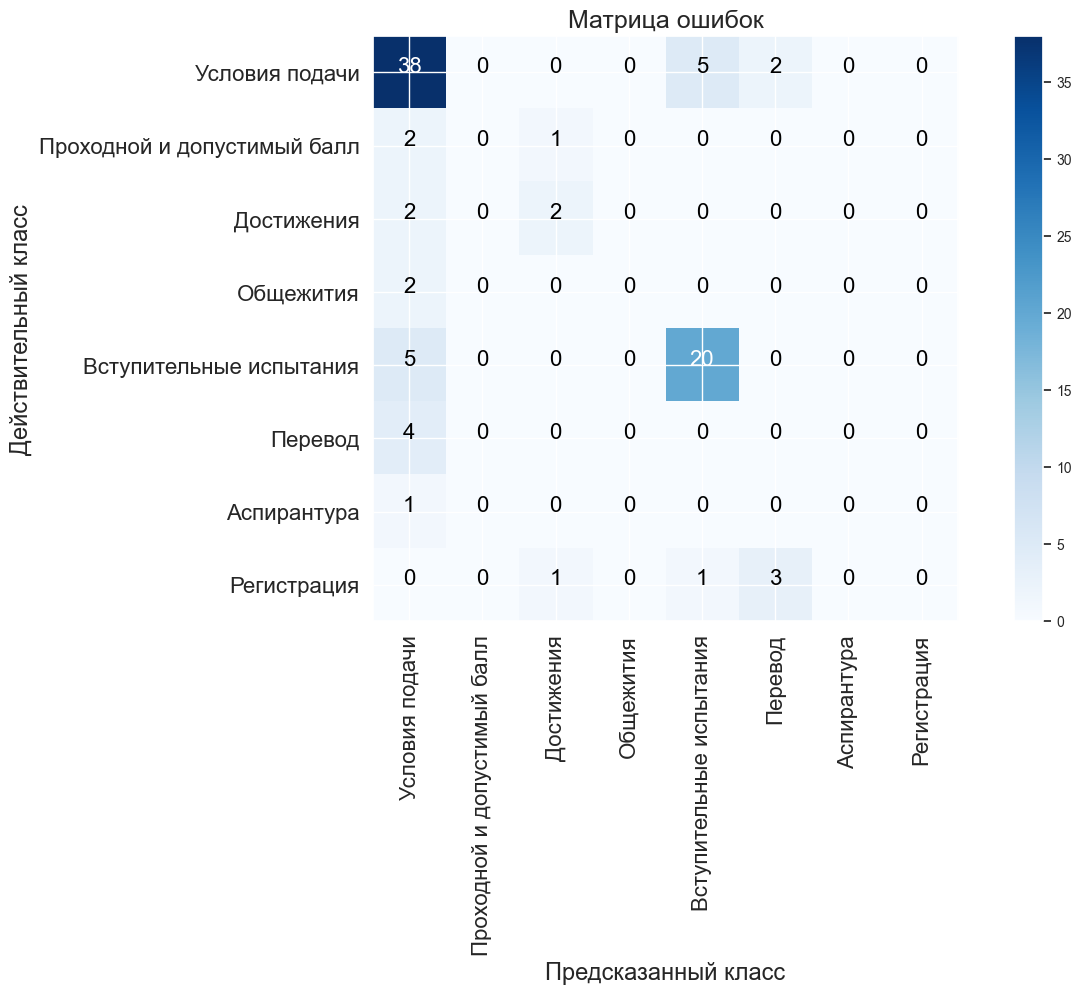

In [41]:
from keras.layers import GRU
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(GRU(32, dropout=0.0, recurrent_dropout=0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_hinge',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

--------------------------------------

## Задача 3. - Применение других методов машинного обучения

### Методы классификации, отличные от логистической регрессии: например, случайный лес (Random Forest), поддерживающие векторы машин (SVM), наивный байесовский классификатор.

Случайный лес отлично работает с высокоразмерными данными.

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

              precision    recall  f1-score   support

           1       0.54      0.93      0.68        45
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.27      0.12      0.17        25
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.51        89
   macro avg       0.10      0.13      0.11        89
weighted avg       0.35      0.51      0.39        89



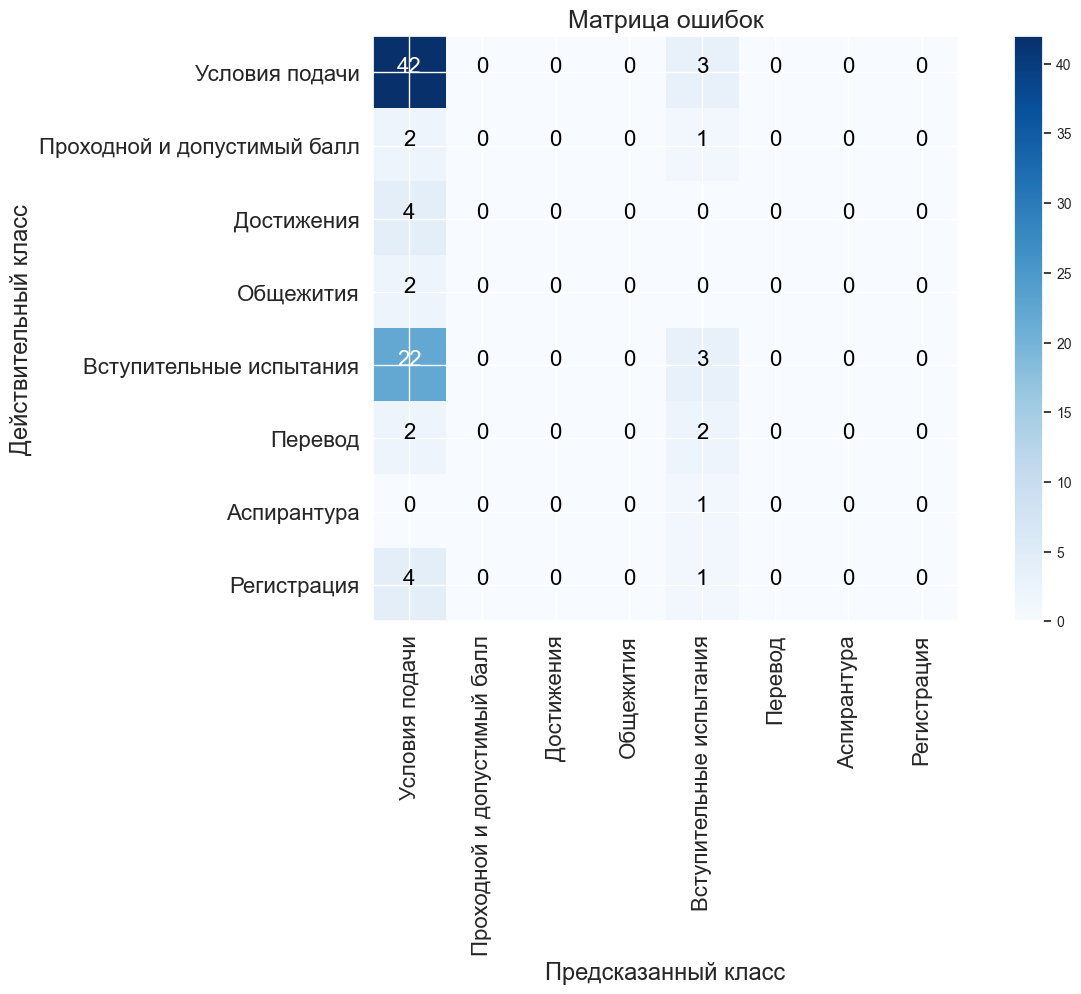

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_train = np.argmax(y_train, axis=1) - 1
Y_test = np.argmax(y_test, axis=1) - 1

# Инициализация и обучение модели случайного леса
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # Параметры можно настроить
clf.fit(X_train, Y_train)  # Обучение

# Предсказание классов тестовых данных
y_pred = clf.predict(X_test) + 1  # Предсказание и коррекция на 1

# Оценка качества модели
y2 = np.array(y_test_1.to_list())
pred2 = np.array(y_pred)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list, f_size=16)


Наивный байесовский классификатор хорошо работает с текстовыми данными

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

              precision    recall  f1-score   support

           1       1.00      0.02      0.04        45
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        25
           6       0.17      0.50      0.25         4
           7       0.00      0.00      0.00         1
           8       0.05      0.60      0.10         5

    accuracy                           0.07        89
   macro avg       0.15      0.14      0.05        89
weighted avg       0.52      0.07      0.04        89



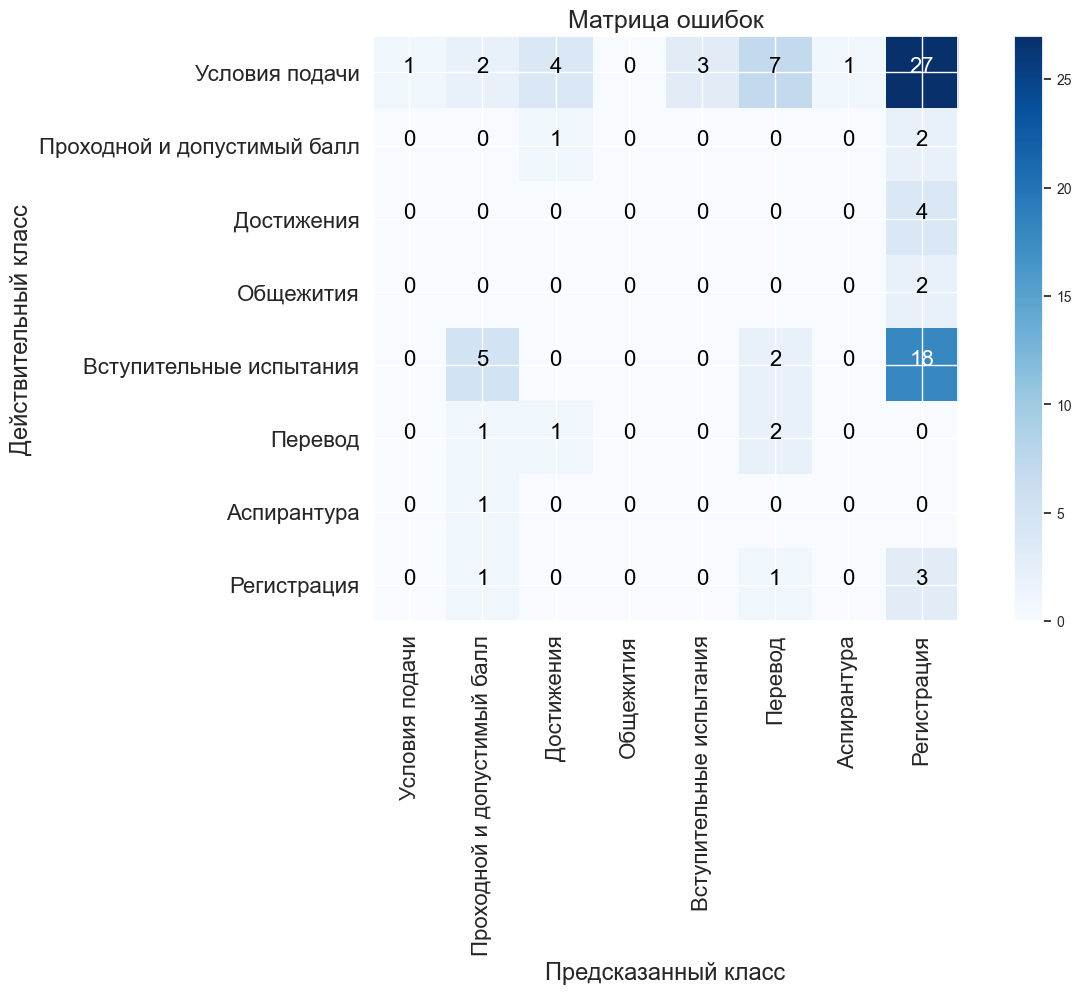

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_train = np.argmax(y_train, axis=1) - 1
Y_test = np.argmax(y_test, axis=1) - 1

# Инициализация и обучение Наивного Байесовского классификатора
clf = GaussianNB()
clf.fit(X_train, Y_train)  # Обучение

# Предсказание классов тестовых данных
y_pred = clf.predict(X_test) + 1  # Предсказание и коррекция на 1

# Оценка качества модели
y2 = np.array(y_test_1.to_list())
pred2 = np.array(y_pred)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list, f_size=16)


KNN прост и эффективен для небольших наборов данных

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

              precision    recall  f1-score   support

           1       0.49      0.82      0.62        45
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.17      0.08      0.11        25
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.44        89
   macro avg       0.08      0.11      0.09        89
weighted avg       0.30      0.44      0.34        89



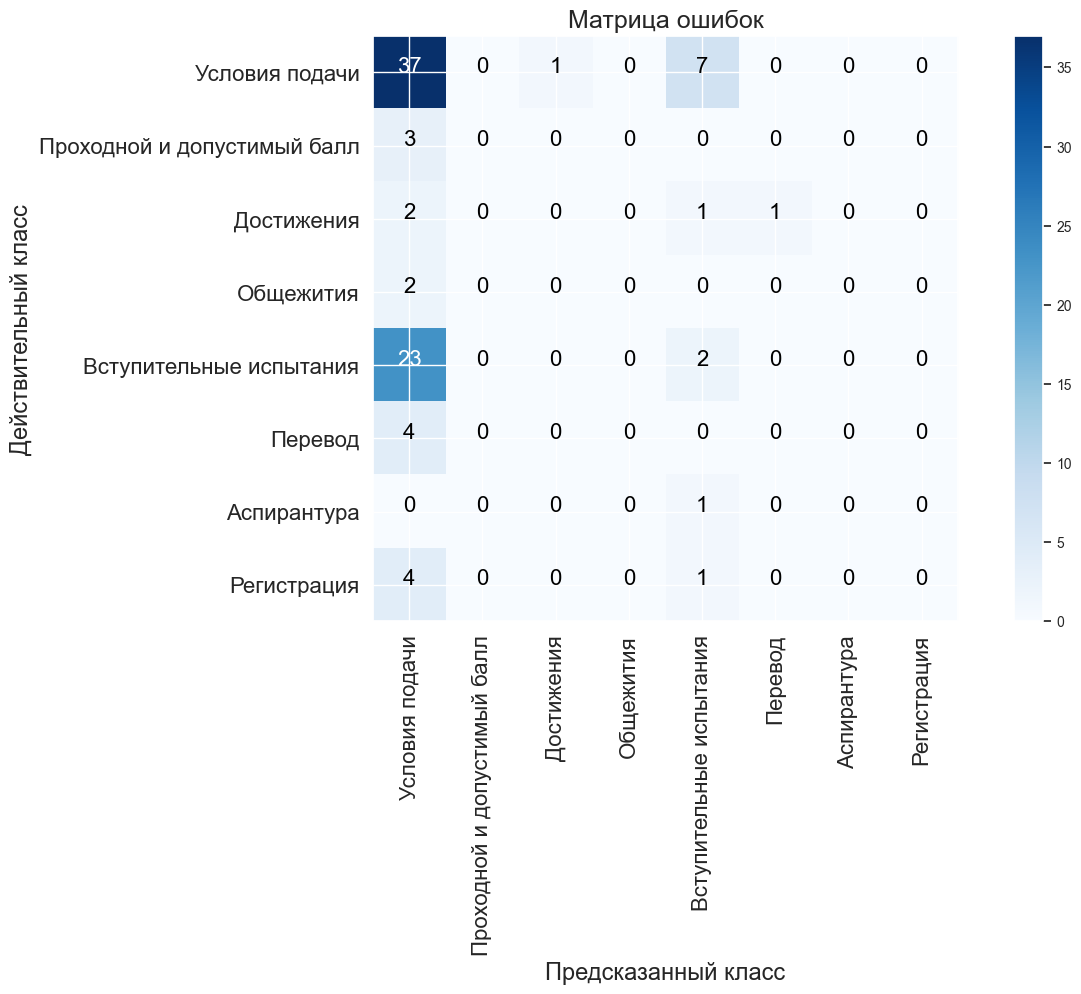

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_train = np.argmax(y_train, axis=1) - 1
Y_test = np.argmax(y_test, axis=1) - 1

# Инициализация и обучение модели KNN
clf = KNeighborsClassifier(n_neighbors=5)  # Параметр n_neighbors можно настроить
clf.fit(X_train, Y_train)  # Обучение

# Предсказание классов тестовых данных
y_pred = clf.predict(X_test) + 1  # Предсказание и коррекция на 1

# Оценка качества модели
y2 = np.array(y_test_1.to_list())
pred2 = np.array(y_pred)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list, f_size=16)


### Комбинации методов (каскады): можно использовать ансамблевые методы, такие как градиентный бустинг или стекинг, для объединения нескольких моделей в одну более мощную модель.

Градиентный бустинг подходит для сложных задач, где необходима высокая точность

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

              precision    recall  f1-score   support

           1       0.55      0.82      0.66        45
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.40      0.24      0.30        25
           6       0.25      0.25      0.25         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.49        89
   macro avg       0.15      0.16      0.15        89
weighted avg       0.40      0.49      0.43        89



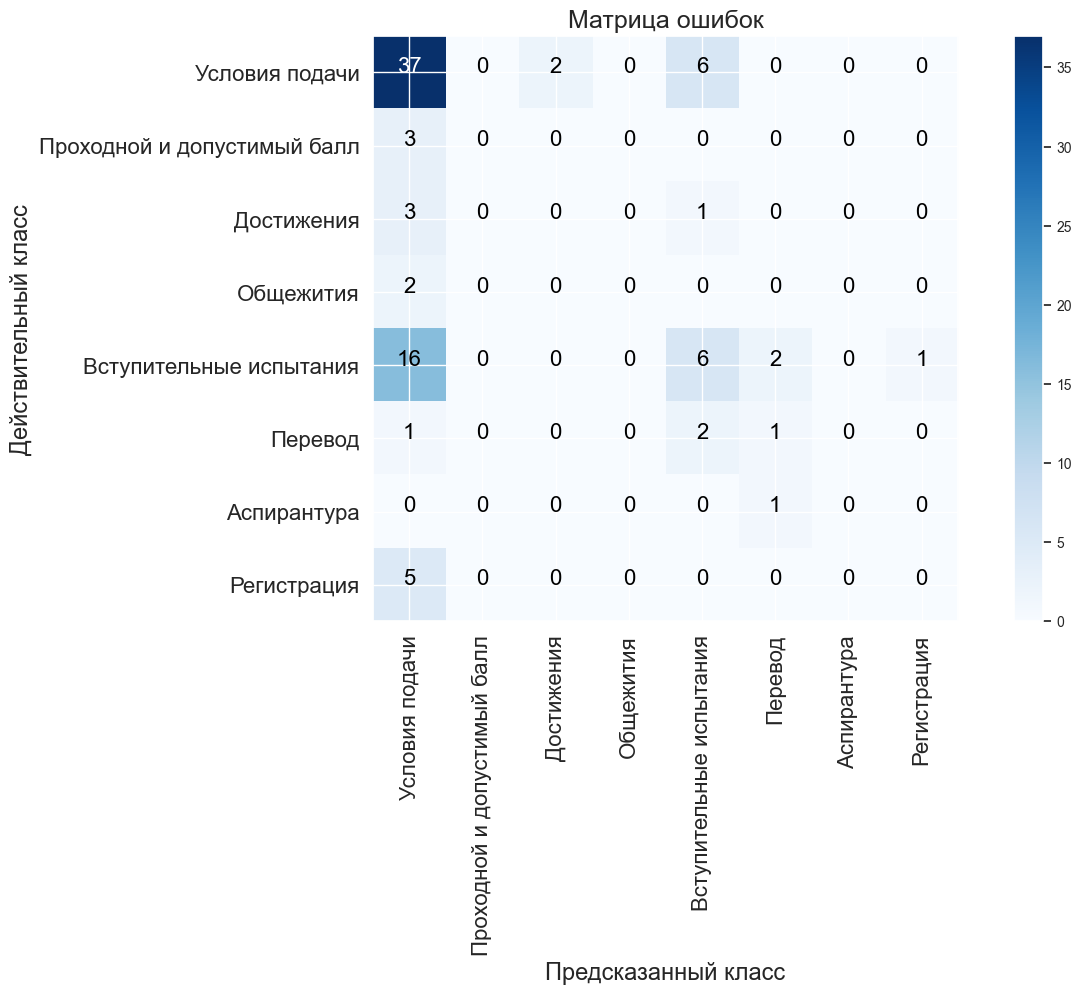

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_train = np.argmax(y_train, axis=1)-1
Y_test = np.argmax(y_test, axis=1)-1

# Инициализация и обучение модели градиентного бустинга
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
clf.fit(X_train, Y_train)  # Обучение

# Предсказание классов тестовых данных
y_pred = clf.predict(X_test) + 1

# Оценка качества модели
y2 = np.array(y_test_1.to_list())
pred2 = np.array(y_pred)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list, f_size=16)


Стекинг позволяет объединить сильные стороны разных моделей и, как правило, приводит к лучшему результату, чем использование одной модели.

d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
d:\_petrsu\data_analysis_in_python\008_classification_text_data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

              precision    recall  f1-score   support

           1       0.52      0.96      0.68        45
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.57      0.16      0.25        25
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.53        89
   macro avg       0.14      0.14      0.12        89
weighted avg       0.43      0.53      0.41        89



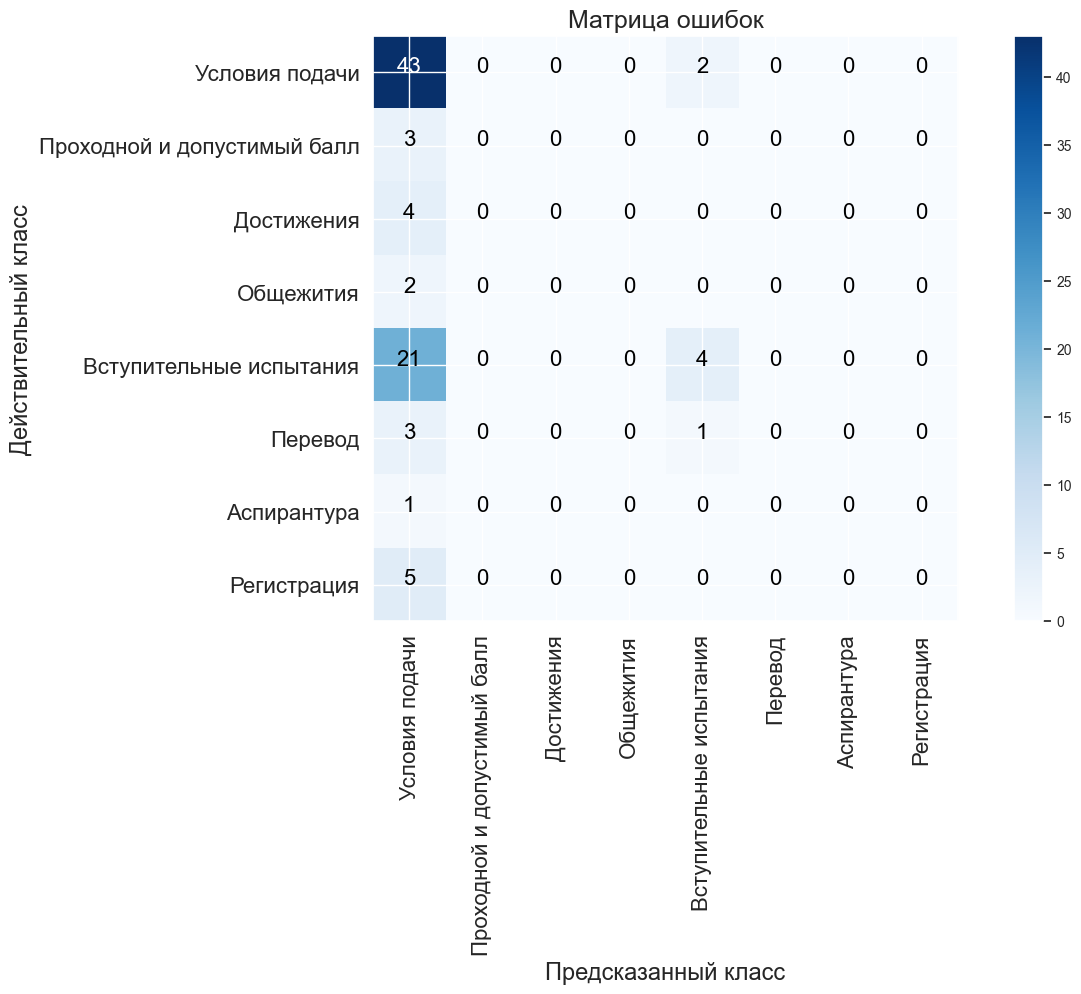

In [46]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

Y_train = np.argmax(y_train, axis=1)-1
Y_test = np.argmax(y_test, axis=1)-1

# Заменили XGBClassifier на GradientBoostingClassifier
estimators = [('RandomForestClassifier', RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             max_features=2)),
              ('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=100)),
              ('Tree', DecisionTreeClassifier(max_depth=5))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, Y_train)  # Обучение
y_pred = clf.predict(X_test)+1  # Предсказание классов тестовых данных
y2 = np.array(y_test_1.to_list())
pred2 = np.array(y_pred)

print(classification_report(y2, pred2))
conf_matr = confusion_matrix(y2, pred2)
plot_confusion_matrix(conf_matr, cls_list, f_size=16)
